#### 位图

如何实现网页爬虫中的URL去重功能

需支持操作：
* 查询 url
* 添加 url
需支持的性能：
* 操作快速
* 内存消耗

单列表、红黑树、跳表可支持快速操作，但是内存消耗大
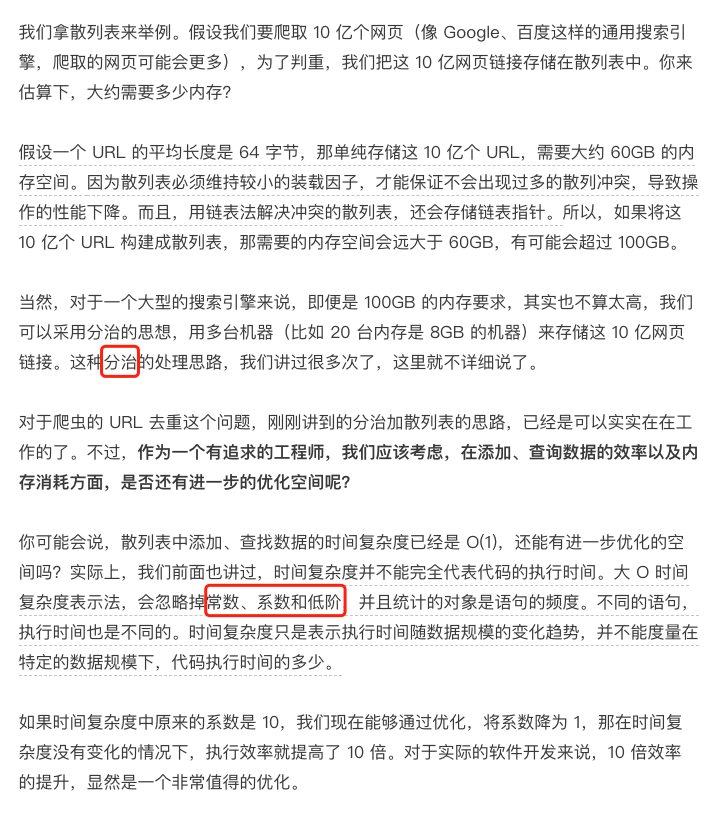







#### 位图 BitMap

Q: 有一千万个整数，数据在 1 ~ 1亿之间，如何快读查找某个整数是否存在？
A: 申请一个大小为 1亿、数据类型为布尔类型的数据
* 遍历一千万个数据，将数据对应的下标置为 true -> array[2]=true -> 整数2存在
* 布尔类型的大小为1个字节，可以换成一个二进制位（bit）来表示


存储 1 千万的数据，数据是 32 位的整型数，也就是需要 4 个字节的存储空间，
* 散列表 存储，总共至少需要 40MB 的存储空间。
* 位图 存储，数字范围在 1 到 1 亿之间，只需要 1 亿个二进制位，也就是 12MB 左右的存储空间就够
  
~~~
public class BitMap { // Java中char类型占16bit，也即是2个字节
  private char[] bytes;
  private int nbits;
  
  public BitMap(int nbits) {
    this.nbits = nbits;
    this.bytes = new char[nbits/16+1];
  }

  public void set(int k) {
    if (k > nbits) return;
    int byteIndex = k / 16;
    int bitIndex = k % 16;
    bytes[byteIndex] |= (1 << bitIndex);
  }

  public boolean get(int k) {
    if (k > nbits) return false;
    int byteIndex = k / 16;
    int bitIndex = k % 16;
    return (bytes[byteIndex] & (1 << bitIndex)) != 0;
  }
}
~~~


##### 位运算
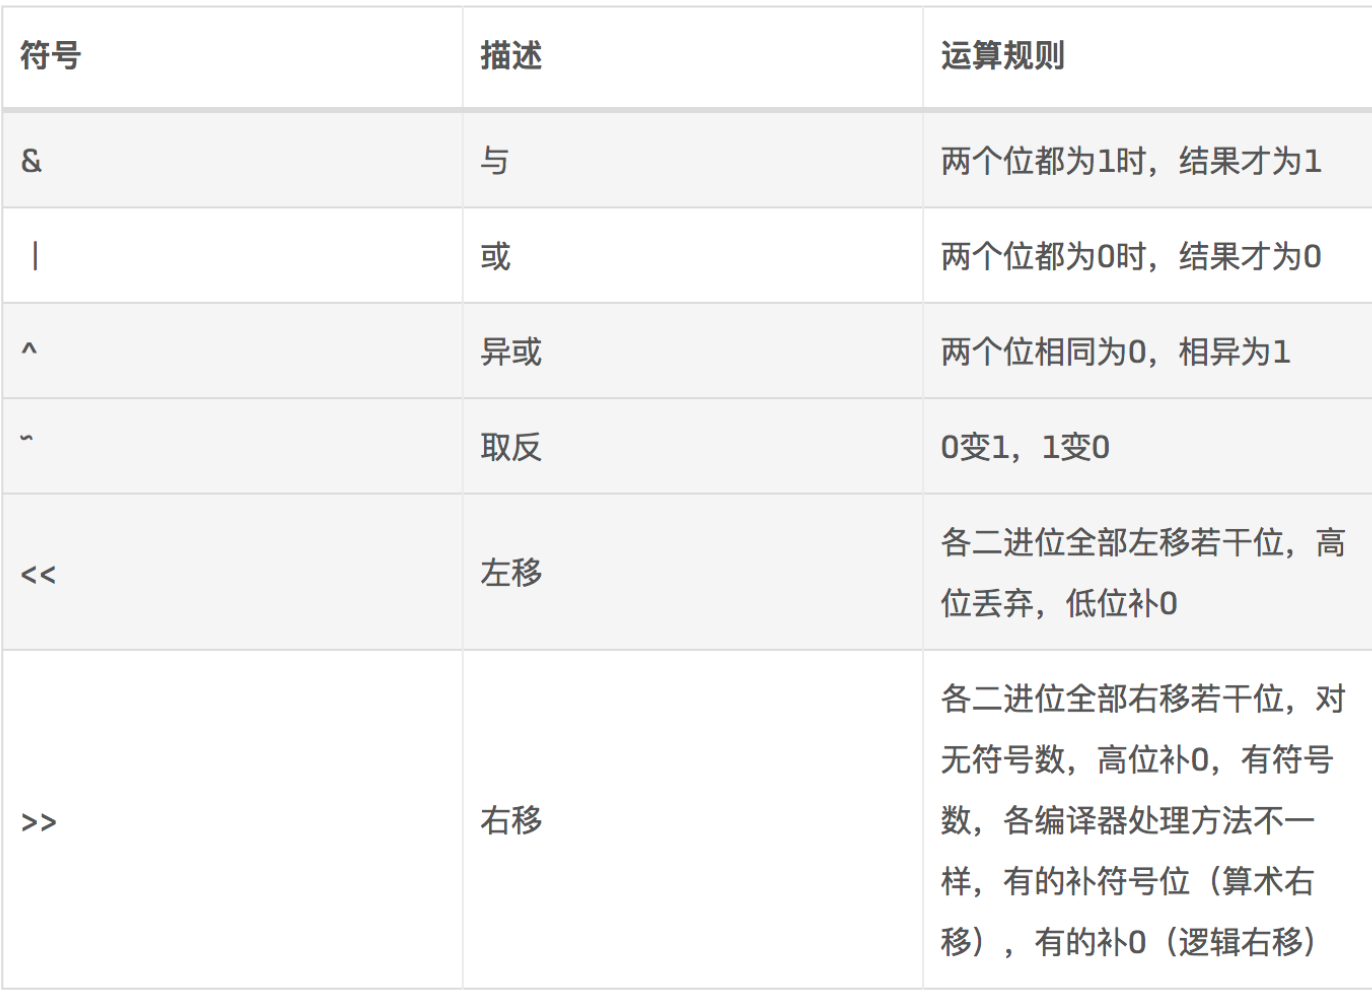

1s: 全是1
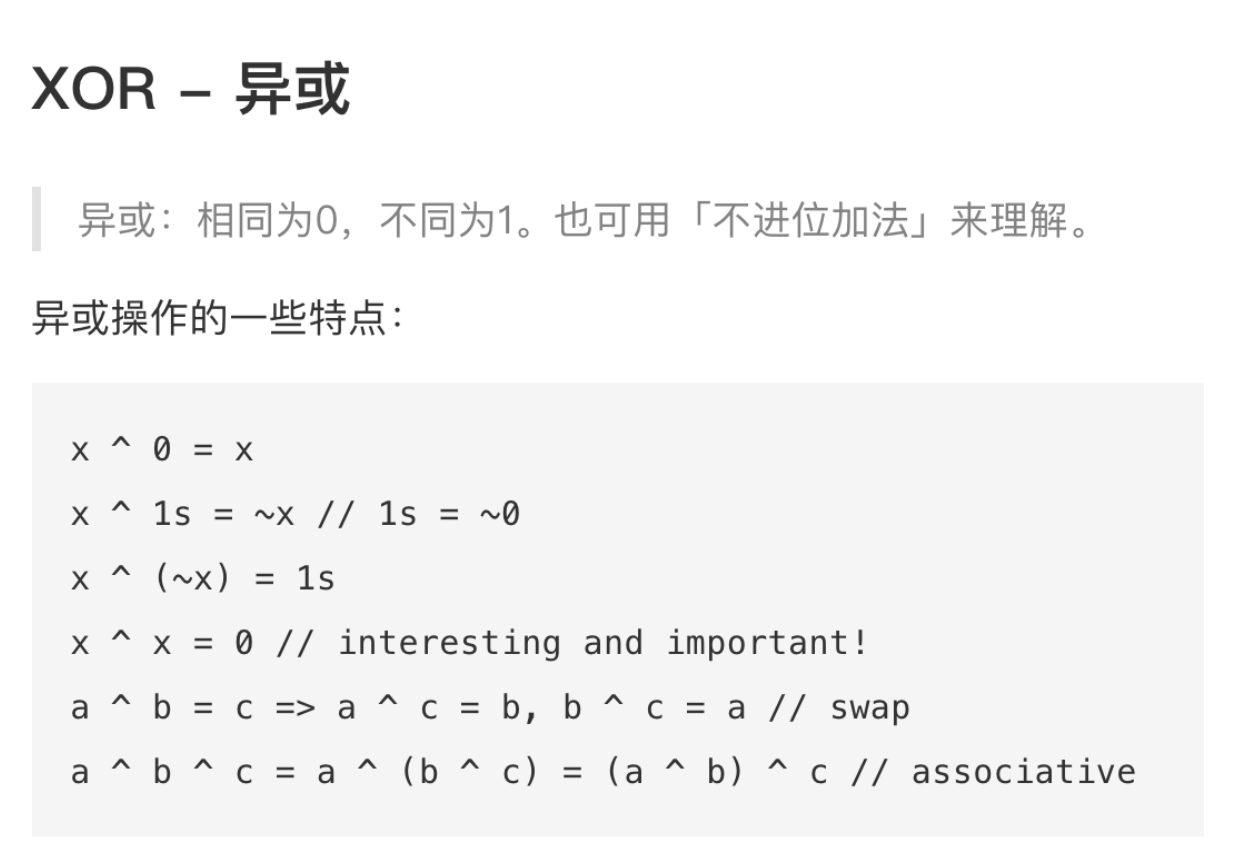

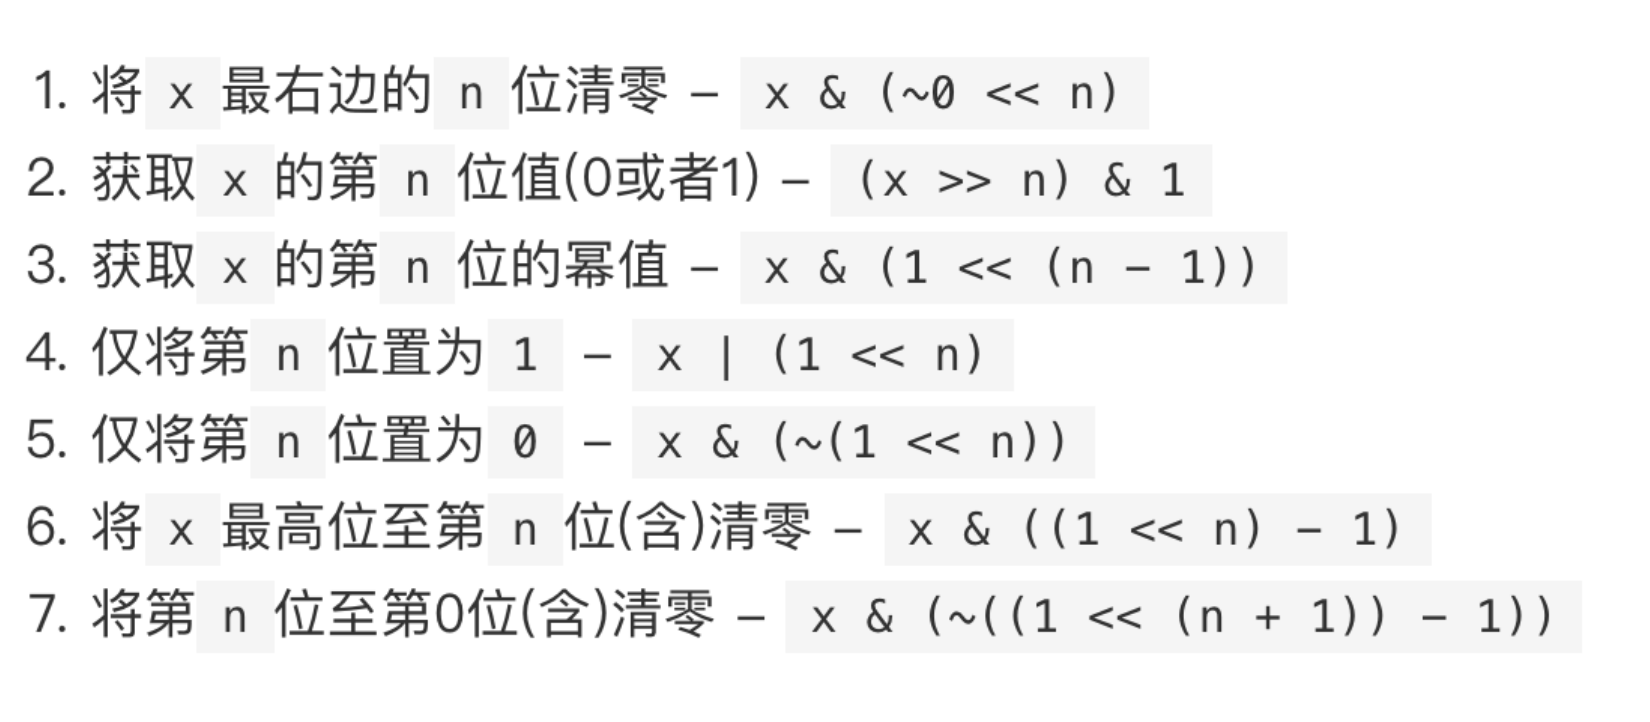

##### 编程常⽤的位运算操作
* X & 1 == 1 OR == 0
* X = X & (X-1) => 清零最低位的1
* X & -X => 得到最低位的1
* X & ~X => 0

#### 布隆过滤器（Bloom Filter）

如果数字的范围很大，数字范围不是 1 到 1 亿，而是 1 到 10 亿，那位图的大小就是 10 亿个二进制位，也就是 120MB 的大小，消耗的内存空间，不降反增。

布隆过滤器的做法是，仍然使用一个 1 亿个二进制大小的位图，然后通过哈希函数，对数字进行处理，让它落在这 1 到 1 亿范围内
* 假设 哈希函数设计成 f(x)=x%n
* 哈希函数会存在冲突的问题，一亿零一和 1 两个数字，经过你刚刚那个取模求余的哈希函数处理之后，最后的结果都是 1。这样无法区分，位图存储的是 1 还是一亿零一了。


布隆过滤器 `使用 K 个哈希函数`
* 使用 K 个哈希函数，对同一个数字进行求哈希值，那会得到 K 个不同的哈希值
  * 分别记作 X1​，X2​，X3​，…，XK​。我们把这 K 个数字作为位图中的下标
* 将对应的 BitMap[X1​]，BitMap[X2​]，BitMap[X3​]，…，BitMap[XK​]都设置成 true -> 用 K 个二进制位，来表示一个数字的存在
* 当要查询某个数字是否存在的时候，我们用同样的 K 个哈希函数，对这个数字求哈希值
  * 分别得到 Y1​，Y2​，Y3​，…，YK​。
* 对应位图中的数值是否都为 true，如果都是 true，则说明，这个数字存在，如果有其中任意一个不为 true，那就说明这个数字不存在。

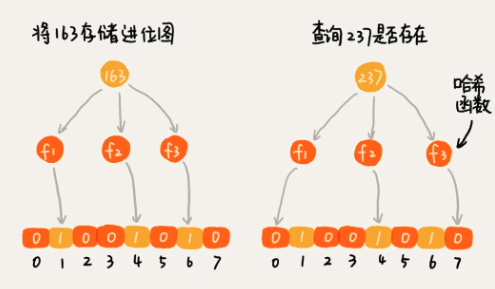

经过 K 个哈希函数处理之后，K 个哈希值都相同的概率就非常低了。
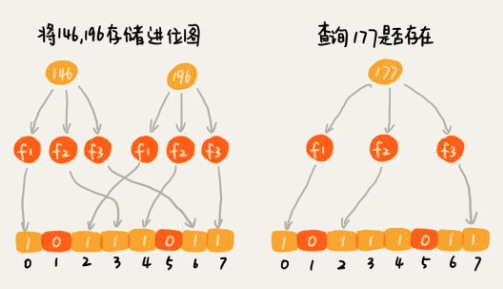
误判问题：
* 如果某个数字经过布隆过滤器判断不存在，那说明这个数字真的不存在，不会发生误判；
* 如果某个数字经过布隆过滤器判断存在，这个时候才会有可能误判，有可能并不存在。

`只要调整哈希函数的个数、位图大小跟要存储数字的个数之间的比例，可以将这种误判的概率降到非常低`
且 很多场景对误判有一定容忍度。比如爬虫

总结：
* 布隆过滤器非常适合这种不需要 100% 准确的、允许存在小概率误判的大规模判重场景。除了爬虫网页去重这个例子，还有比如统计一个大型网站的每天的 UV 数，也就是每天有多少用户访问了网站，我们就可以使用布隆过滤器，对重复访问的用户进行去重。
* 布隆过滤器的误判率，主要跟哈希函数的个数、位图的大小有关。当我们往布隆过滤器中不停地加入数据之后，位图中不是 true 的位置就越来越少了，误判率就越来越高了。所以，对于无法事先知道要判重的数据个数的情况，我们需要支持自动扩容的功能。
* 当布隆过滤器中，数据个数与位图大小的比例超过某个阈值的时候，我们就重新申请一个新的位图。后面来的新数据，会被放置到新的位图中。但是，如果我们要判断某个数据是否在布隆过滤器中已经存在，我们就需要查看多个位图，相应的执行效率就降低了一些。
* 位图、布隆过滤器应用如此广泛，很多编程语言都已经实现了。比如 Java 中的 BitSet 类就是一个位图，Redis 也提供了 BitMap 位图类，Google 的 Guava 工具包提供了 BloomFilter 布隆过滤器的实现

#### 网页去重

Q: 假设需要判重的网页有 10 亿，那我们可以用一个 10 倍大小的位图来存储，也就是 100 亿个二进制位，换算成字节，那就是大约 1.2GB。之前我们用散列表判重，需要至少 100GB 的空间。相比来讲，布隆过滤器在存储空间的消耗上，降低了非常多。

布隆过滤器用多个哈希函数对同一个网页链接进行处理
* CPU 只需要将网页链接从内存中读取一次，进行多次哈希计算，理论上讲这组操作是 CPU 密集型的
* 而在散列表的处理方式中，需要读取散列值相同（散列冲突）的多个网页链接，分别跟待判重的网页链接，进行字符串匹配。这个操作涉及很多内存数据的读取，所以是内存密集型的。
*  CPU 计算可能是要比内存访问更快速的，所以，理论上讲，布隆过滤器的判重方式，更加快速。

In [ ]:
'''
191. Number of 1 Bits Easy

Write a function that takes the binary representation of a positive integer and returns the number of 
set bits
 it has (also known as the Hamming weight).

 

Example 1:

Input: n = 11

Output: 3

Explanation:

The input binary string 1011 has a total of three set bits.
'''

class Solution:
    def hammingWeight(self, n: int) -> int:
        return self.hammingWeight02(n)

    def hammingWeight02(self, n: int) -> int:
        res = 0
        while n != 0:
            res += 1
            n = n & n-1
        return res

    def hammingWeight01(self, n: int) -> int:
        res = 0
        while n > 0:
            # if n % 2 == 1: == n & 1 ==1
            if n & 1 == 1:
                res += 1
            n = n >> 1

        return res

In [ ]:
'''
231. Power of Two Easy

Given an integer n, return true if it is a power of two. Otherwise, return false.

An integer n is a power of two, if there exists an integer x such that n == 2x.

 

Example 1:

Input: n = 1
Output: true
Explanation: 20 = 1
Example 2:

Input: n = 16
Output: true
Explanation: 24 = 16
'''

class Solution:
    def isPowerOfTwo(self, n: int) -> bool:
        # n 不能为0 且 pow(2,x) 的二进制表示只会有一个1，n&n-1 -> 清除最后一个1，则剩下权威0
        return n != 0 and not (n & n-1)    


In [ ]:
'''
338. Counting Bits Easy

Given an integer n, return an array ans of length n + 1 such that for each i (0 <= i <= n), ans[i] is the number of 1's in the binary representation of i.

 

Example 1:

Input: n = 2
Output: [0,1,1]
Explanation:
0 --> 0
1 --> 1
2 --> 10

'''

class Solution:
    def countBits(self, n: int) -> List[int]:
        return self.countBits02(n)
    
    def countBits02(self, n: int) -> List[int]:
        res = [0] * (n+1)
        for i in range(1, n+1):
            res[i] = res[i&i-1]+1
        return res

    def countBits01(self, n: int) -> List[int]:
        res = []
        for i in range(n+1):
            res.append(self.hammingWeight(i))
        return res

    
    def hammingWeight(self, n: int) -> int:
        res = 0
        while n != 0:
            res += 1
            n = n & n-1
        return res

        